# Assignment - 7 (Amazon Fine Food Reviews Analysis)

Title: Making predictions and doing exploratory analysis over Amazon Fine Food Reviews dataset <br>

Author: Shashank Ramesh

Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

Relevant Information: The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>


Description: The purpose of this task is to do an in-depth analysis of the fine food reviews given by the customers at amazon.com and find relations between the attributes, extract relevant facts and also make a prediction model using Naive Bayes (Multinomial NB used) to predict given a review for it to be positive or negetive.


Number of Instances: 568,454<br>
Number of Attributes: 10 (including the class attribute)

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review




## 1. Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, I have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

con = sqlite3.connect('database.sqlite') #reading from the database file

filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) #filtering only positive and negative reviews i.e. not taking into consideration reviews with Score=3

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

Score = filtered_data['Score']
Score = Score.map(partition) #changing reviews with score less than 3 to be positive and vice-versa
filtered_data['Score'] = Score

In [2]:
filtered_data.shape #looking at the number of attributes and size of the data

(525814, 10)

# 2 Analysis of the data

## 2.1 Deduplication

It is observed on doing analysis (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. 

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

It can be seen above that we have used subset={"UserId","ProfileName","Time","Text"} and not included parameters like HelpfulnessNumerator,HelpfulnessDenominator,Score etc. as on doing so we found entries like the one below which had different values of the above parameters but the same timestamp user and review text hence chose those parameters for deduplication according to the basic logic that one customer cannot type-in multiple reviews with different Summaries at exactly at the same timestamp (i.e. within 1ms)

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="A1R6PBUJB8LBGC"
ORDER BY ProductID
""", con)
display[:3]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,435043,B000HDJXLW,A1R6PBUJB8LBGC,"Stretch ""Stretch""",2,7,1,1266451200,Agreed? No BPA!,Muir Glen cans are lined in plastic and leach ...
1,459852,B000LKTZNM,A1R6PBUJB8LBGC,"Stretch ""Stretch""",2,2,1,1266451200,Not without BPA,Muir Glen cans are lined in plastic and leach ...
2,456867,B000LKTZSM,A1R6PBUJB8LBGC,"Stretch ""Stretch""",10,13,1,1266451200,Organic endocrine disruptor!?,Muir Glen cans are lined in plastic and leach ...


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
final.shape

(364171, 10)

## 2.2 Preprocessing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = ' '.join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)
    i+=1

In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [14]:
final.head(3) #below the processed review can be seen in the CleanedText Column 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


## 2.3 Words Analysis

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [14]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(5))
print("Most Common Negative Words : ",freq_dist_negative.most_common(5))

('Most Common Positive Words : ', [('like', 139429), ('tast', 129047), ('good', 112766), ('flavor', 109624), ('love', 107357)])
('Most Common Negative Words : ', [('tast', 34585), ('like', 32330), ('product', 28218), ('one', 20569), ('flavor', 19575)])


Let's see what are the number of unique words describing positive and negative reviews

In [15]:
unique_positive_words=list(set(all_positive_words))
unique_negative_words=list(set(all_negative_words))
print("Number of unique words describing positive sentiment : ",len(unique_positive_words))
print("Number of unique words describing positive sentiment : ",len(unique_negative_words))

('Number of unique words describing positive sentiment : ', 64750)
('Number of unique words describing positive sentiment : ', 29275)


In [16]:
all_words=unique_positive_words + unique_negative_words
unique_words=set(all_words)
print("Number of unique words used in the reviews : ",len(unique_words))

('Number of unique words used in the reviews : ', 71626)


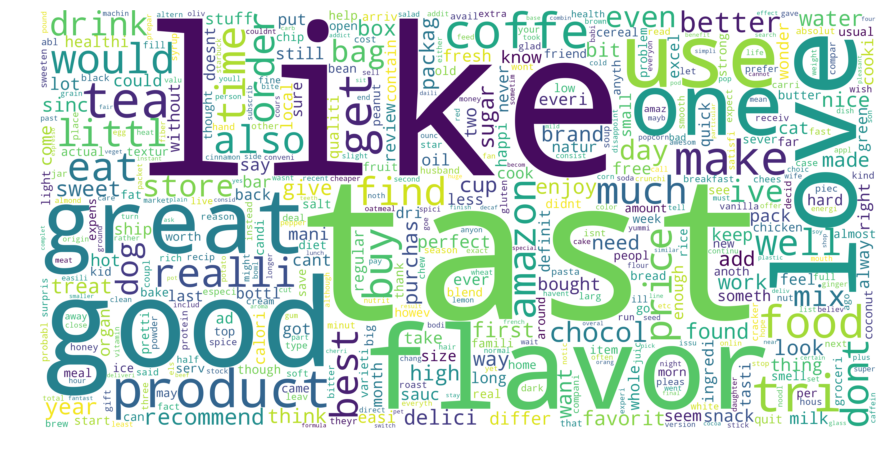

In [21]:
#Visualising the positive words in a wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=4000,height=2000,max_words=500,background_color="white")
wordcloud.generate_from_frequencies(frequencies=freq_dist_positive)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

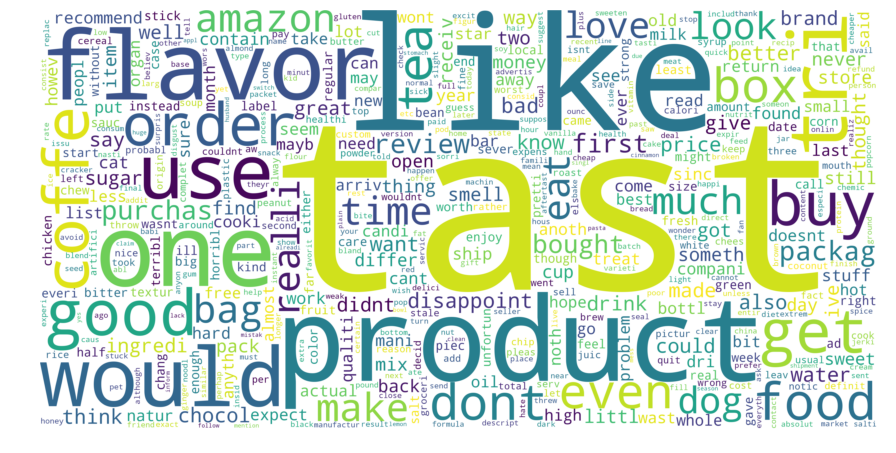

In [68]:
#Visualising the negative words in a wordcloud
wordcloud = WordCloud(width=4000,height=2000,max_words=500,background_color="white")
wordcloud.generate_from_frequencies(frequencies=freq_dist_negative)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc.
Lets now visualise the words which are exclusively present only in positive or negative reviews

In [18]:
#extracting the words that are only present in positive or negative reviews 
common_positive_words=[w for (w,x) in freq_dist_positive.most_common()]
common_negative_words=[w for (w,x) in freq_dist_negative.most_common()]
only_positive=set(common_positive_words).difference(set(common_negative_words))
only_negative=set(common_negative_words).difference(set(common_positive_words))

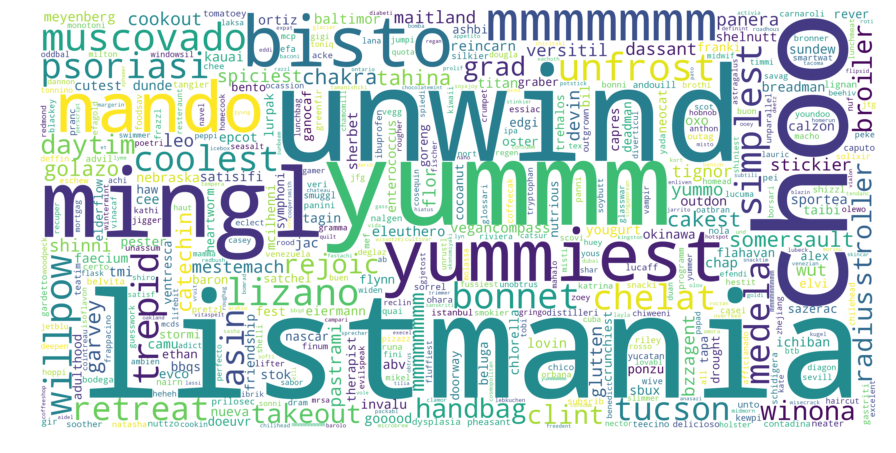

In [22]:
#visualising the words that are only present in positive reviews in wordclouds 
pos_data={}
for i in only_positive:
    pos_data[i] = freq_dist_positive[i]
wordcloud = WordCloud(width=4000,height=2000,max_words=500,background_color="white")
wordcloud.generate_from_frequencies(frequencies=pos_data)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

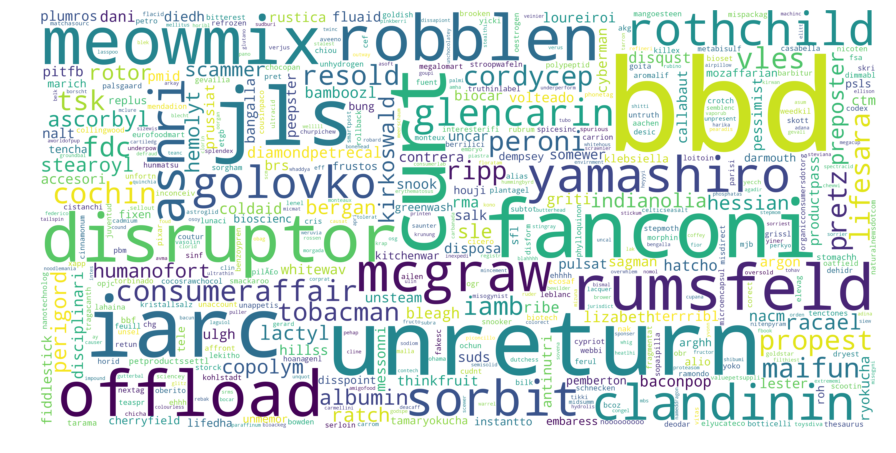

In [23]:
#visualising the words that are only present in negative reviews in wordclouds 
neg_data={}
for i in only_negative:
    neg_data[i] = freq_dist_negative[i]
wordcloud = WordCloud(width=4000,height=2000,max_words=500,background_color="white")
wordcloud.generate_from_frequencies(frequencies=neg_data)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Before we proceed to the next analysis stage lets add a column with the word count of the legitimate words present in our review text as shown below 

In [17]:
#adding a column named WordCount which tells us the number of legitimate words in the review text
final['WordCount']= final['CleanedText'].values
final['WordCount'] = final['WordCount'].apply(lambda i: len(i.split()))

In [18]:
#Displaying WordCount column below
final.tail(50)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,WordCount
109889,119261,B009LSMTWE,A1YIJQ25QOTSMS,Interested Reader,0,0,positive,1349740800,My Favorite Tea,This is a really great tea. Sweat and very fla...,realli great tea sweat flavor hint vinilla dri...,10
165036,178973,B009LT26BC,A16WPA6JV83YXT,"Sandra Trolinger ""trolsgirl""",0,0,positive,1350864000,Perfect strength for those who want a stronger...,This coffee surprised me as I have tried so ma...,coffe surpris tri mani differ cup good truli m...,61
165035,178972,B009LT26BC,A1BYMKR6E2EXEJ,Towel seeker,2,2,positive,1350691200,8 o clock finally in k cups,"I used to use 8 o'clock coffee, both regular a...",use use oclock coffe regular dark standard dri...,42
437126,472734,B009M6W5UQ,A3N4SCF33QI436,Doc Stuart,0,0,positive,1349913600,I've been searching for this stuff! Liquid gold!,I got hooked on Wild Tiger while deployed to I...,got hook wild tiger deploy iraq buy case littl...,45
250231,271312,B009MRNOR8,A39TQGHIPJJMV5,Nicole M. Hanna,0,0,negative,1350604800,90-calorie chocolate cardboard,These are really gross. They taste like 20 cal...,realli gross tast like calori worth chocol pea...,23
184392,200017,B009NEQAHQ,AM2KJSYDRR0KI,Nanette A Corn,0,0,positive,1351036800,Yummy!,I love the taste of this salt. It works in al...,love tast salt work recip wonder raw veggi lik...,33
184393,200018,B009NEQAHQ,A1CN3VUX1DQ0FN,jhusch,0,0,positive,1351036800,"Great taste, beautiful crystal!",My wife and I use this everyday in our dinners...,wife use everyday dinner crystal clean white f...,37
404313,437202,B009NIF7BM,A2VOUS7IL8Y1H5,Kozak82,0,0,positive,1350259200,"Amazing, Just Ask My Guests","After trying this, I thought it was amazing an...",tri thought amaz tast great accompani typic di...,103
404312,437201,B009NIF7BM,A3L9Z3ODGSUCT7,Lucille A. Sakatis,0,0,positive,1350259200,Delicious Organic Olive Oil from Spain !,I decided to try this product after searching ...,decid tri product search organ product onlin c...,100
404311,437200,B009NIF7BM,AG4JL2SKX22W5,A. Ramos,0,0,positive,1351209600,AMAZING FIND!!!,I am a stay at home mom of two small kids and ...,stay home mom two small kid alway look good or...,52


In [22]:
#We also save this format of the final data along with the values in another SQLite table for easy querrying for analysis later
conn = sqlite3.connect('test.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [631]:
conn = sqlite3.connect('test.sqlite')

## 2.3 Time Analysis

In this section we will be analysing the imapact of time on the reviews

In [62]:
t_analysis= pd.read_sql_query("""
SELECT *
FROM Reviews
ORDER BY Time
""", conn)

In [63]:
t_analysis.head(1)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,WordCount
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,35


In [64]:
t_analysis.tail(1)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,WordCount
364172,355171,384161,B000EVWQZW,A2PCNXBSKCABG5,Whit,0,0,positive,1351209600,Versatile Mix,This mix makes a good bread or can also be use...,mix make good bread also use make pop over nea...,19


<b>Observation:-</b>From the above two cells it is seen that the first timestamp is 939340800 corresponsonding to 8th October 1999, 05:30:00 and last timestamp is 1351209600 corresponding to 26th October 2012, 05:30:00

As we know that the period span covered in the reviews are from the year 1999 to 2012 hence now we shall see the plots of<br> 
1. Number of Reviews recieved w.r.t. time
2. Number of Unique Products reviewed w.r.t. time
3. Number of Unique Users reviewing w.r.t. time

In [65]:
#function to help us convert timestamp to date
import datetime
def getDate(stamp):
    return datetime.datetime.fromtimestamp(stamp).strftime('%Y')

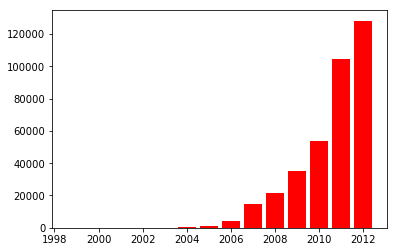

In [66]:
#Plot to see how the number of reviews change w.r.t. time
countR={}
for i in t_analysis['Time']:
    d=getDate(i)
    d=int(d)
    if(countR.has_key(d)):
        countR[d]=countR[d]+1
    else:
        countR[d]=1
plt.bar(countR.keys(), countR.values(), color='r')
plt.show()

In [68]:
i=900000000
x1=[]
y1=[]
x2=[]
y2=[]
while i<1360000000:
    x1.append(i)
    x2.append(i)
    i+=10000000
    y1.append((t_analysis[(t_analysis.Time < i) & (t_analysis.Score=='positive') ]).size/13)
    y2.append((t_analysis[(t_analysis.Time < i) & (t_analysis.Score=='negative') ]).size/13)

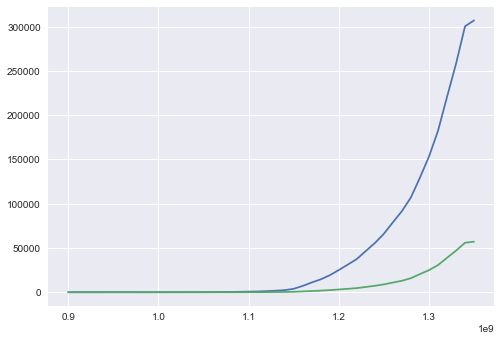

In [69]:
#plot showing variation of positive and negetive reviews with time
import seaborn as sns
sns.set_style("darkgrid")
plt.plot(x1,y1,x2,y2)
plt.show()

<b>Observation:-</b> From the above plot it is clear that customer satisfaction with the quality of Amazon Fine Foods has kept increasing which is shown by the exponential rise in the number of positive reviews and not that much for the negative reviews.

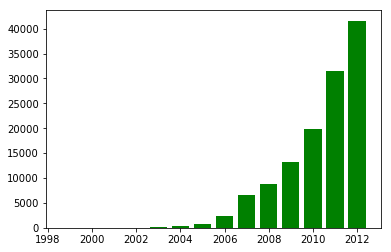

In [37]:
#Plot to see how the number of products reviewed change w.r.t. time
countP={}
time=t_analysis['Time'].values
year=1999
pl=[]
j=0
for i in t_analysis['ProductId']:
    d=getDate(time[j])
    j+=1
    d=int(d)
    if(d!=year):
        pl=list(set(pl))
        countP[year]=len(pl)
        year=d
        pl=[]
        pl.append(i)
    else:
        pl.append(i)
pl=list(set(pl))
countP[d]=len(pl)
plt.bar(countP.keys(), countP.values(), color='g')
plt.show()

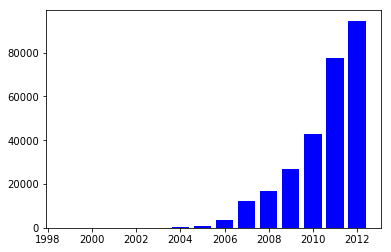

In [38]:
#Plot to see how the number of users reviewing change w.r.t. time
countU={}
time=t_analysis['Time'].values
year=1999
pl=[]
j=0
for i in t_analysis['UserId']:
    d=getDate(time[j])
    j+=1
    d=int(d)
    if(d!=year):
        pl=list(set(pl))
        countU[year]=len(pl)
        year=d
        pl=[]
        pl.append(i)
    else:
        pl.append(i)
pl=list(set(pl))
countU[d]=len(pl)
plt.bar(countU.keys(), countU.values(), color='b')
plt.show()

<b>Observation:-</b> It can be seen from all the plots that there is a rise between values every year showing how Amazon Fine Foods has been piercing into the masses.It is to note that there is a significant rise in values of 2010 to 2011 this tells us that maybe that the reforms or strategies used in this period has done marvels as even the customer satisfaction speaks for the same, inferred by the increasing positive reviews.

## 2.4 Ratings Analysis

In this section we'll be doing analysis based on the rating value that is positive or negative

In [303]:
RatingDetails = pd.read_sql_query("""
SELECT COUNT(Score) AS NumberOfReviews , Score
FROM Reviews
GROUP BY Score
ORDER BY COUNT(Score) desc
""", conn)
RatingDetails.set_index(RatingDetails['Score'],inplace=True)
RatingDetails['NumberOfReviews']=RatingDetails['NumberOfReviews']/364173*100
RatingDetails

,NumberOfReviews,Score
Score,,
positive,84.317893,positive
negative,15.682107,negative


<b>Observation:-</b> It can be seen from the above plot that the positive reviews constitue about ~84% of the number of reviews hence the dataset is imbalanced

In [304]:
RatingDetails = pd.read_sql_query("""
SELECT Score,COUNT(Score) AS NumberOfReviews , AVG(WordCount) AS AverageWordsUsed,AVG(HelpfulnessNumerator/HelpfulnessDenominator)*100 AS HelpfulnessDegree
FROM Reviews
GROUP BY Score
ORDER BY COUNT(Score) desc
""", conn)
RatingDetails

,Score,NumberOfReviews,AverageWordsUsed,HelpfulnessDegree
0,positive,307063,37.699925,73.720840
1,negative,57110,41.112922,30.023289


In [305]:
RatingDetails = pd.read_sql_query("""
SELECT Score, HelpfulnessNumerator, HelpfulnessDenominator,WordCount
FROM Reviews
""", conn)
RatingDetails['HelpfulnessDegree']=(RatingDetails['HelpfulnessNumerator']*1.0/RatingDetails['HelpfulnessDenominator']*1.0)*100
RatingDetails=RatingDetails[RatingDetails.HelpfulnessDegree <= 100]
RatingDetails = RatingDetails[np.isfinite(RatingDetails['HelpfulnessDegree'])]

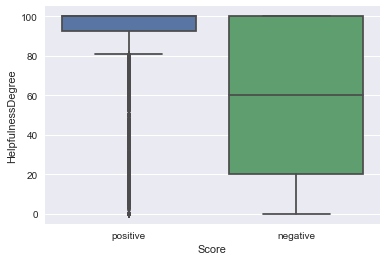

In [306]:
#plotting Score vs HelpfulnessDegree=(HelpfulnessNumerator/HelpfulnessDenominator)*100
import seaborn as sns
sns.boxplot(x='Score',y='HelpfulnessDegree', data=RatingDetails)
plt.show()

<b>Observation:-</b> From the above plot it can be inferred that positive reviews are more helpful than negative reviews as the mean of the HelpfulnessDegree for positive is way greater than that of negative reviews.

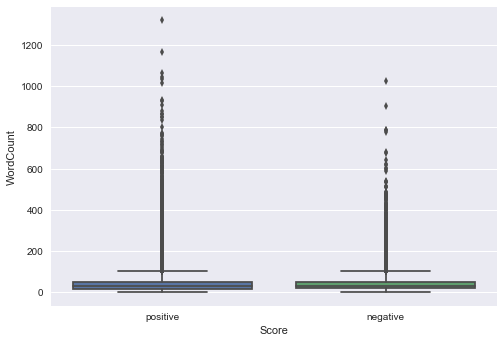

In [68]:
sns.boxplot(x='Score',y='WordCount', data=RatingDetails)
plt.show()

<b>Observation:-</b> We cannot distinguish much from the plot but the mean-line of WordCount in negative reviews seems to be a bit higher than that in the WordCount in positive reviews

In [307]:
import math
RatingDetails = pd.read_sql_query("""
SELECT Score, WordCount
FROM Reviews
""", conn)

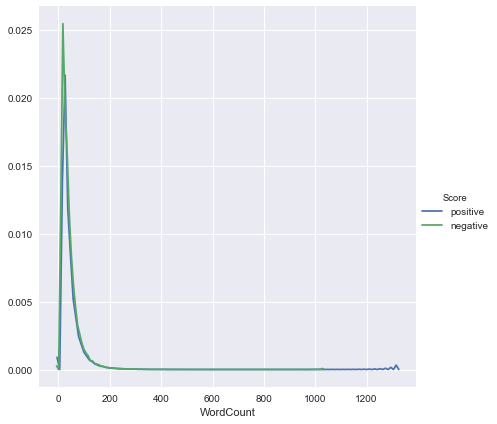

In [308]:
sns.FacetGrid(RatingDetails,hue='Score',size=6) \
   .map(sns.kdeplot, "WordCount") \
   .add_legend();
plt.show();

<b>Observation:-</b> It was observed that the number of words (word count) in the Reviews ( Positive,Negetive and Total) are Log-Normal distributed and hence as shown below converted each value to its log and as shown below we have a normal distribution of data.

In [309]:
RatingDetails = pd.read_sql_query("""
SELECT WordCount
FROM Reviews
""", conn)
RatingDetails['WordCount']=RatingDetails[RatingDetails.WordCount>0]
RatingDetails.WordCount = RatingDetails.WordCount.astype(float)
RatingDetails['WordCount']=RatingDetails['WordCount'].apply(lambda i: math.log(i))

In [352]:
import scipy.stats as s
s.anderson(RatingDetails['WordCount'].values, dist='norm')

AndersonResult(statistic=nan, critical_values=array([ 0.58,  0.66,  0.79,  0.92,  1.09]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

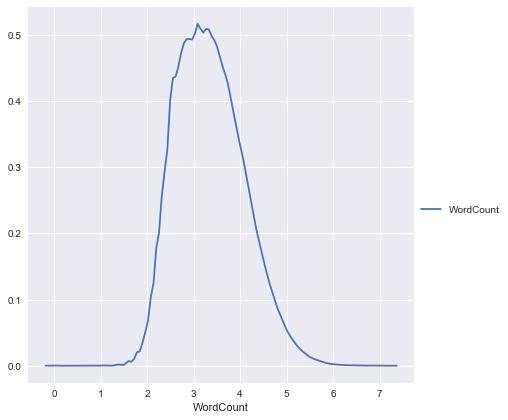

In [121]:
sns.FacetGrid(RatingDetails, size=6) \
   .map(sns.kdeplot, "WordCount") \
   .add_legend();
plt.show();

## 2.5 Customers Analysis

In this section we will be analysing the users customers giving the reviews to help us do so we would be adding a few new terminologies :- <br>
<b>Negativity</b> - It is a measure to see if Negative Reviews are more than Positive Reviews<br>
<b>DegreeOfPositivity</b> - It is a measure of the Number of Positive Reviews out of the Total Number Of Reviews given by a user  
<b>FrequentReviewer</b> - Is a user who has given more than 50 reviews. There are 92 such reviewers who have submitted more than 50 reviews out of 243414 unique users.

In [632]:
UserDetails = pd.read_sql_query("""
SELECT COUNT(UserId) AS NumberOfReviews,UserId, ProfileName,SUM(Score='positive') AS PositiveReviews,SUM(Score='negative') AS NegetiveReviews, AVG(HelpfulnessNumerator/HelpfulnessDenominator)*100 AS HelpfulnessDegree,COUNT(UserId)>50 AS FrequentReviewer,AVG(WordCount) AS WordsUsed,SUM(Score='negative')>SUM(Score='positive') AS Negativity  
FROM Reviews
GROUP BY UserId
ORDER BY FrequentReviewer,Negativity desc, NumberOfReviews desc
""", conn)
UserDetails[:5]


,NumberOfReviews,UserId,ProfileName,PositiveReviews,NegetiveReviews,HelpfulnessDegree,FrequentReviewer,WordsUsed,Negativity
0,49,AKZKG2Z7CNV27,BreezyPaige,15,34,60.869565,0,135.510204,1
1,46,A2TN9C5E4A0I3F,Jimmy,20,26,44.444444,0,46.847826,1
2,30,A1Z7XV6JU0EV8M,"Barbara ""Barbara""",7,23,31.578947,0,18.666667,1
3,25,A11YOTONCPRQ9S,SH,12,13,52.941176,0,35.240000,1
4,22,A2WS6FMF750EI9,"Amy Steele ""quirky mama""",9,13,42.857143,0,47.863636,1


In [633]:
UserDetails['DegreeOfPositivity']=UserDetails['PositiveReviews']*1.0/UserDetails['NumberOfReviews']*1.0
UserDetails[:5]

,NumberOfReviews,UserId,ProfileName,PositiveReviews,NegetiveReviews,HelpfulnessDegree,FrequentReviewer,WordsUsed,Negativity,DegreeOfPositivity
0,49,AKZKG2Z7CNV27,BreezyPaige,15,34,60.869565,0,135.510204,1,0.306122
1,46,A2TN9C5E4A0I3F,Jimmy,20,26,44.444444,0,46.847826,1,0.434783
2,30,A1Z7XV6JU0EV8M,"Barbara ""Barbara""",7,23,31.578947,0,18.666667,1,0.233333
3,25,A11YOTONCPRQ9S,SH,12,13,52.941176,0,35.240000,1,0.480000
4,22,A2WS6FMF750EI9,"Amy Steele ""quirky mama""",9,13,42.857143,0,47.863636,1,0.409091


In [23]:
UserDetails = pd.read_sql_query("""
SELECT COUNT(UserId) AS NumberOfUserReviews,UserId,COUNT(UserId)>50 AS FrequentReviewer,SUM(Score='positive') AS PositiveReviews
FROM Reviews
GROUP BY UserId
ORDER BY FrequentReviewer desc
""", conn)
UserDetails[:5]

,NumberOfUserReviews,UserId,FrequentReviewer,PositiveReviews
0,64,A1080SE9X3ECK0,1,61
1,56,A132ETQPMHQ585,1,40
2,72,A17HMM1M7T9PJ1,1,69
3,72,A1GYEGLX3P2Y7P,1,72
4,79,A1HRYC60VTMYC0,1,78


In [24]:
UserDetails['DegreeOfPositivity']=UserDetails['PositiveReviews']*1.0/UserDetails['NumberOfUserReviews']*1.0
del UserDetails['PositiveReviews']
UserDetails[:5]

,NumberOfUserReviews,UserId,FrequentReviewer,DegreeOfPositivity
0,64,A1080SE9X3ECK0,1,0.953125
1,56,A132ETQPMHQ585,1,0.714286
2,72,A17HMM1M7T9PJ1,1,0.958333
3,72,A1GYEGLX3P2Y7P,1,1.000000
4,79,A1HRYC60VTMYC0,1,0.987342


In [30]:
conn = sqlite3.connect('errors.sqlite')
c=conn.cursor()
conn.text_factory = str
UserDetails.to_sql('Users', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

<b>Observation:-</b> It is seen from the query run above <b>(ORDER BY FrequentReviewer desc,Negativity desc)</b> that there is no Frequent Reviewer such that Negativity = 1 or where the number of negative reviews given by the Frequent Reviewer is more than the number of positive reviews.

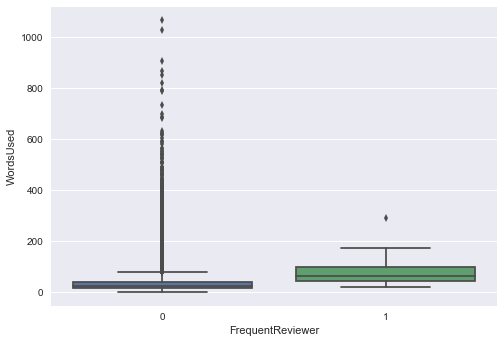

In [205]:
sns.boxplot(x='FrequentReviewer',y='WordsUsed', data=UserDetails)
plt.show()

<b>Observation:-</b> It is observed from the above plot that the  Number of Words used in reviews by Frequent Reviewers is more as compared to that in the reviews of Non-frequent customers

In [206]:
UserDetails = UserDetails[np.isfinite(UserDetails['HelpfulnessDegree'])]

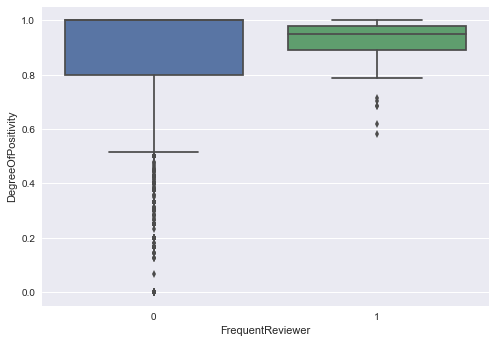

In [207]:
sns.boxplot(x='FrequentReviewer',y='DegreeOfPositivity', data=UserDetails)
plt.show()

<b>Observation:-</b> In General all users tend to write more positive reviews but in particular, Frequent Reviewers generally write a very few negetive reviews when compared to the total number of reviews given by him.

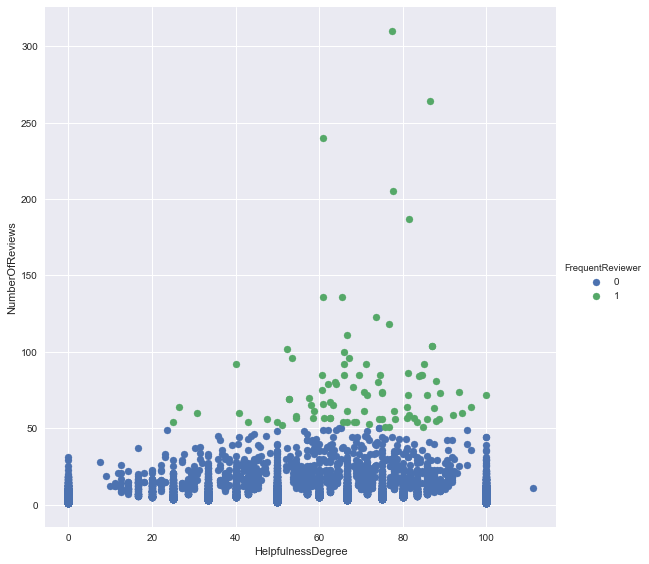

In [214]:
sns.FacetGrid(UserDetails, hue="FrequentReviewer", size=8) \
   .map(plt.scatter, "HelpfulnessDegree", "NumberOfReviews") \
   .add_legend();
plt.show();

<b>Observation:-</b> Reviews given by frequent reviewers are generally very helpful as seen in the above plot

In [316]:
UserDetails = pd.read_sql_query("""
SELECT WordCount  
FROM Reviews
WHERE UserId="A3OXHLG6DIBRW8"
""", conn)

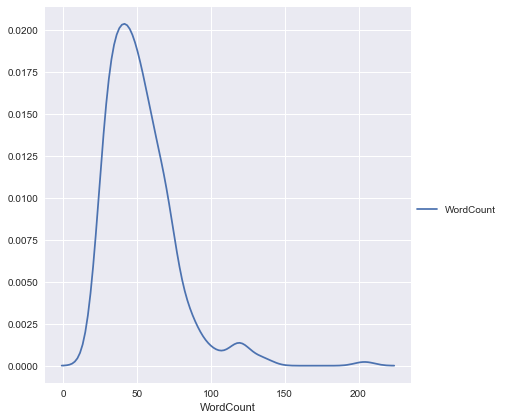

In [133]:
sns.FacetGrid(UserDetails, size=6) \
   .map(sns.kdeplot, "WordCount") \
   .add_legend();
plt.show();

<b>Observation:-</b> The WordCount distribution for Frequent Reviewers were taken and it was observed that it is log-normally distributed hence applied log to all the values to transform the distribution into normal distribution. 

In [317]:
UserDetails['WordCount']=UserDetails[UserDetails.WordCount>0]
UserDetails.WordCount = UserDetails.WordCount.astype(float)
UserDetails['WordCount']=UserDetails['WordCount'].apply(lambda i: math.log(i))

In [318]:
import scipy.stats as s
s.anderson(UserDetails['WordCount'].values, dist='norm')

AndersonResult(statistic=0.5707074113007593, critical_values=array([ 0.57,  0.65,  0.78,  0.91,  1.08]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

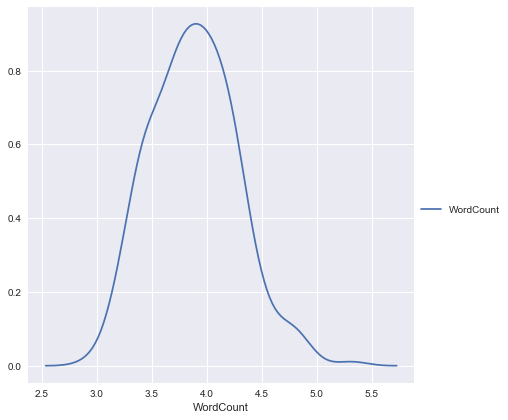

In [135]:
sns.FacetGrid(UserDetails, size=6) \
   .map(sns.kdeplot, "WordCount") \
   .add_legend();
plt.show();

## 2.6 Products Analysis

In this section we would be analysing the reviews based on product details so we would be adding a few new terminologies :- <br>
<b>Negativity</b> - It is a measure to see if Negative Reviews are more than Positive Reviews<br>
<b>DegreeOfPositivity</b> - It is a measure of the Number of Positive Reviews out of the Total Number Of Reviews given by a user  
<b>FrequentReviewedProduct</b> - Is a product which has received more than 50 reviews. There are 838 such products out of the 65442 unique products.

In [25]:
ProductDetails = pd.read_sql_query("""
SELECT COUNT(ProductId) AS NumberOfReviews , ProductId, SUM(Score='positive') AS PositiveReviews,SUM(Score='negative') AS NegetiveReviews,COUNT(UserId)>50 AS FrequentReviewedProduct,AVG(WordCount) AS WordsUsed,AVG(HelpfulnessNumerator/HelpfulnessDenominator)*100 AS HelpfulnessDegree,SUM(Score='negative')>SUM(Score='positive') AS Negativity
FROM Reviews 
GROUP BY ProductId 
ORDER BY NumberOfReviews desc
""", conn)
ProductDetails['DegreeOfPositivity']=ProductDetails['PositiveReviews']*1.0/ProductDetails['NumberOfReviews']*1.0
ProductDetails[:5]

,NumberOfReviews,ProductId,PositiveReviews,NegetiveReviews,FrequentReviewedProduct,WordsUsed,HelpfulnessDegree,Negativity,DegreeOfPositivity
0,856,B007JFMH8M,840,16,1,24.163551,85.185185,0,0.981308
1,609,B0026RQTGE,571,38,1,28.635468,68.944099,0,0.937603
2,598,B003B3OOPA,585,13,1,43.814381,78.554779,0,0.978261
3,551,B001EO5Q64,538,13,1,46.246824,77.419355,0,0.976407
4,532,B000NMJWZO,527,5,1,35.056391,86.559140,0,0.990602


In [26]:
ProductDetails = pd.read_sql_query("""
SELECT COUNT(ProductId) AS NumberOfProductReviews , ProductId, SUM(Score='positive') AS PositiveReviews,COUNT(UserId)>50 AS FrequentReviewedProduct
FROM Reviews 
GROUP BY ProductId 
ORDER BY FrequentReviewedProduct desc
""", conn)
ProductDetails['DegreeOfPositivity']=ProductDetails['PositiveReviews']*1.0/ProductDetails['NumberOfProductReviews']*1.0
ProductDetails[:5]

,NumberOfProductReviews,ProductId,PositiveReviews,FrequentReviewedProduct,DegreeOfPositivity
0,164,7310172001,160,1,0.975610
1,180,B00004CI84,169,1,0.938889
2,164,B00004RAMY,133,1,0.810976
3,89,B00004RBDU,68,1,0.764045
4,54,B00004RBDZ,37,1,0.685185


In [27]:
del ProductDetails['PositiveReviews']

In [28]:
ProductDetails[:5]

,NumberOfProductReviews,ProductId,FrequentReviewedProduct,DegreeOfPositivity
0,164,7310172001,1,0.975610
1,180,B00004CI84,1,0.938889
2,164,B00004RAMY,1,0.810976
3,89,B00004RBDU,1,0.764045
4,54,B00004RBDZ,1,0.685185


In [29]:
conn = sqlite3.connect('errors.sqlite')
c=conn.cursor()
conn.text_factory = str
ProductDetails.to_sql('Products', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [192]:
ProductDetails = ProductDetails[np.isfinite(ProductDetails['HelpfulnessDegree'])]

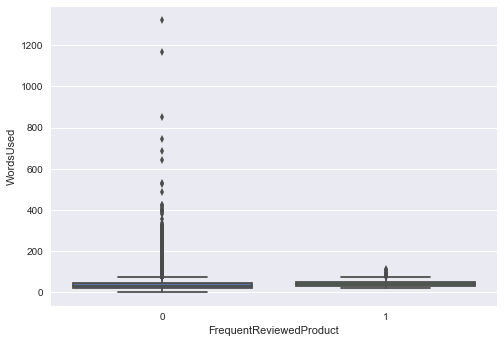

In [193]:
import seaborn as sns
sns.boxplot(x='FrequentReviewedProduct',y='WordsUsed', data=ProductDetails)
plt.show()

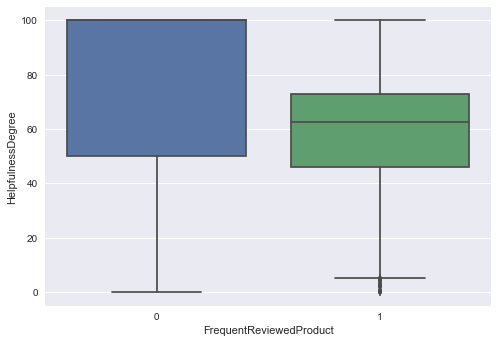

In [194]:
import seaborn as sns

sns.boxplot(x='FrequentReviewedProduct',y='HelpfulnessDegree', data=ProductDetails)
plt.show()

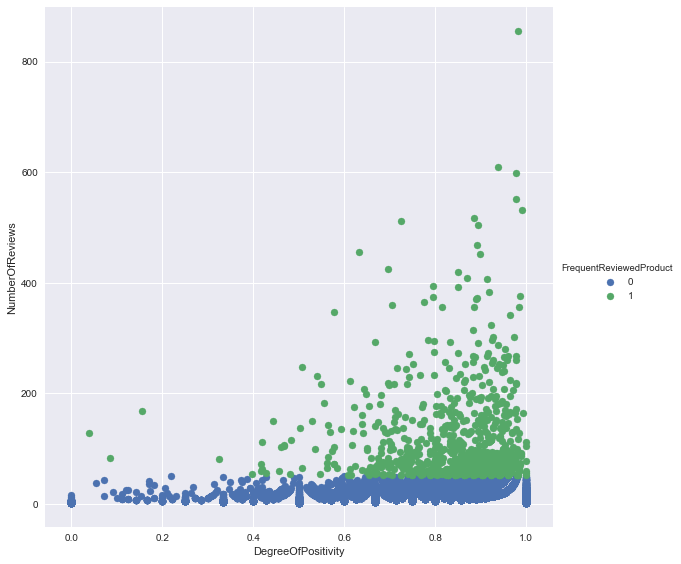

In [216]:
sns.FacetGrid(ProductDetails, hue="FrequentReviewedProduct", size=8) \
   .map(plt.scatter, "DegreeOfPositivity", "NumberOfReviews") \
   .add_legend();
plt.show();

<b>Observation:-</b> From the above graph it is clear that frequently reviewed products are generally given more positive reviews

In [220]:
ProductDetails = pd.read_sql_query("""
SELECT WordCount
FROM Reviews
WHERE ProductId="B007JFMH8M"
""", conn)

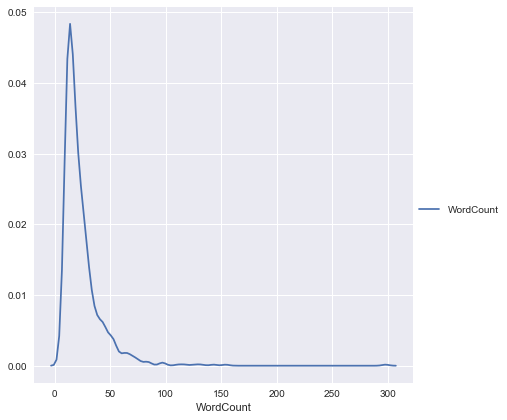

In [221]:
sns.FacetGrid(ProductDetails, size=6) \
   .map(sns.kdeplot, "WordCount") \
   .add_legend();
plt.show();

<b>Observation:-</b> The WordCount distribution for Frequently Reviewed products were taken and it was observed that it is log-normally distributed hence applied log to all the values to transform the distribution into normal distribution.

In [222]:
ProductDetails['WordCount']=ProductDetails[ProductDetails.WordCount>0]
ProductDetails.WordCount = ProductDetails.WordCount.astype(float)
ProductDetails['WordCount']=ProductDetails['WordCount'].apply(lambda i: math.log(i))

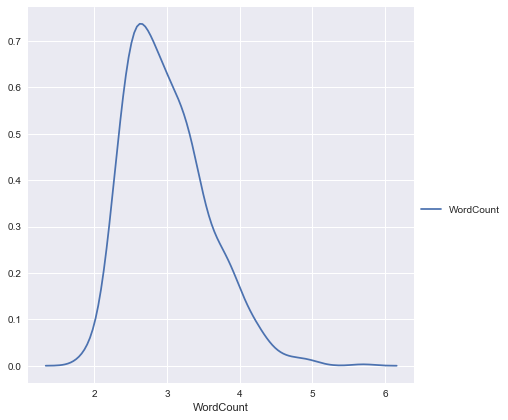

In [223]:
sns.FacetGrid(ProductDetails, size=6) \
   .map(sns.kdeplot, "WordCount") \
   .add_legend();
plt.show();

## 2.6 Summary Analysis

<b>Observation:-</b> On analysis of the summary field an interesting obserevation was found wherein the presence of special character '!' gave us the idea of a review being negetive or positive as shown below. It gives us a accuracy of 84.87% in separating a positive reviews from negetive reviews

In [224]:
SummaryDetails = pd.read_sql_query("""
SELECT Summary,Score
FROM Reviews 
""", conn)

In [604]:
i=0
pos_count=0
neg_count=0
for s in final['Summary'].values:
    if(s.find('!')!=-1):
        continue
    else:
        if (final['Score'].values)[i] == 'positive':
            pos_count+=1
        else:
            neg_count+=1
    i+=1
pos_count,neg_count

(230244, 41024)

# 3. Predicting Models

Now after we have done a lot of exploratory data analysis we will now be focusing on delving deep into optimization and choosing of the right model for prediction of reviews to be positive or negative.<br><br>
The approach folowed will be to try all different variations in our first-cut model and then narrowing down and going deeper into optimization to acheive the best results

## 3.1 Featurizations

Among the various featurizations possible for text data we would be comparing amongst the following to see which of them gives us the best results <br>

Before we start we need to make sure that we separate our train and test corpus and hence it was decided to do a 70%-30% split after sorting the reviews based on their time cast i.e. we would be using the corpus of reviews cast

In [33]:
final.sort_values('Time', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
train_corpus=(final['CleanedText'].values)[:255000]
test_corpus=(final['CleanedText'].values)[255000:]

In [34]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_corpus)
X_test_counts = count_vect.transform(test_corpus)

In [35]:
tf_idf_vect = TfidfVectorizer()
X_train_tfidf = tf_idf_vect.fit_transform(train_corpus)
X_test_tfidf = tf_idf_vect.transform(test_corpus)

In [37]:
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                if(cleaned_words.lower() not in stop):
                    filtered_sentence.append(cleaned_words.lower().encode('utf8'))
                else:
                    continue
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [38]:
w2v_features=gensim.models.Word2Vec(list_of_sent,min_count=5,size=100, workers=4)

In [39]:
all_word_vectors_matrix = w2v_features.wv.syn0
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(all_word_vectors_matrix[:5000])

In [41]:
words=[]
for i in range(5000):
    your_word_vector = all_word_vectors_matrix[i]
    a=w2v_features.most_similar(positive=[your_word_vector], topn=1)
    words.append(str(a[0][0]))
x = [i[1] for i in tsne_results ]
y = [i[0] for i in tsne_results ]

In [42]:
points = pd.DataFrame()
points['word']=words
points['x']=x
points['y']=y

## 3.1 Self-Implementation of Naive Bayes Algo

<b>Probability Calculation</b>

In [18]:
corpus=final['CleanedText'].values
corpus=corpus[:255890]
all_positive_words1=[]
all_negative_words1=[]
all_words1=[]
i=0
for j in corpus:
    all_words1+=(j.split())
    if (final['Score'].values)[i] == 'positive': 
        all_positive_words1+=(j.split())
    if(final['Score'].values)[i] == 'negative':
        all_negative_words1+=(j.split())
    i+=1

In [19]:
len(all_negative_words1)

1578273

In [20]:
len(all_positive_words1)

7980576

In [21]:
freq_dist_positive1=nltk.FreqDist(all_positive_words1)
freq_dist_negative1=nltk.FreqDist(all_negative_words1)

In [22]:
prob_word_given_positive={}
for x in freq_dist_positive1:
    prob_word_given_positive[x]=(freq_dist_positive1[x]+1)*1.0/((len(all_positive_words1)+2)*1.0)
prob_word_given_positive['like']

0.011459570973430746

In [23]:
prob_word_given_negative={}
for x in freq_dist_negative1:
    prob_word_given_negative[x]=(freq_dist_negative1[x]+1)*1.0/((len(all_negative_words1)+2)*1.0)
prob_word_given_negative['like']

0.013064896801888137

<b>Feature Importance in Naive Bayes</b>

In [24]:
import operator
imp={}
for x in unique_words:
    imp[x]=abs((prob_word_given_positive.get(x, 0)-prob_word_given_negative.get(x, 0)))
sorted_imp = sorted(imp.items(), key=operator.itemgetter(1))
sorted_imp.reverse()
x1=[ i[0] for i in sorted_imp]
y1=[ i[1] for i in sorted_imp]

In [25]:
x1[:5]

['great', 'love', 'product', 'tast', 'good']

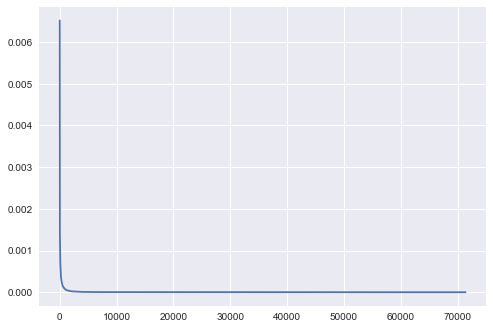

In [26]:
#plot showing variation of importance
import seaborn as sns
sns.set_style("darkgrid")
plt.plot(y1)
plt.show()

<b>Testing</b>

In [27]:
test_s=final[255890:]
sc=final['Score'].values
y_test=[]
j=0
y_pred=[]
for senten in test_s['CleanedText']:
    test_sent=senten
    pos_prob=1
    neg_prob=1
    for i in test_sent.split():
        pos_prob*=prob_word_given_positive.get(i,1.0/(len(all_positive_words)+2)*1.0)
        neg_prob*=prob_word_given_negative.get(i,1.0/(len(all_negative_words)+2)*1.0)
    if(pos_prob>=neg_prob):
        y_pred.append('positive')
    if(pos_prob<neg_prob):
        y_pred.append('negative')
    y_test.append(sc[j])
    j+=1

<b>Evaluation Metrics</b>

In [28]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred,labels=['positive','negative'])
cm

array([[69648, 22576],
       [12044,  4013]])

In [29]:
print(metrics.classification_report(y_test,y_pred, target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.15      0.25      0.19     16057
   negative       0.85      0.76      0.80     92224

avg / total       0.75      0.68      0.71    108281



## 3.2 Logistic Regression

<b>Division of Train-Test Sets</b>

In [30]:
corpus=final['CleanedText'].values
corpus=corpus[:255000]
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(corpus)

In [20]:
X_train_counts

<255000x2300999 sparse matrix of type '<type 'numpy.int64'>'
	with 16956381 stored elements in Compressed Sparse Row format>

In [31]:
corpus=final['CleanedText'].values
corpus=corpus[255000:]
X_new_counts = count_vect.transform(corpus)

<b>Hyperparameter Search</b>

In [74]:
from sklearn.model_selection import GridSearchCV
C_range=[0.1,1,10]
logreg = linear_model.LogisticRegression()

In [75]:
param_grid=dict(C=C_range)
param_grid

{'C': [0.1, 1, 10]}

In [78]:
grid= GridSearchCV(logreg, param_grid, cv=10, verbose=10, scoring='accuracy', n_jobs=-1)

In [79]:
grid.fit(X_train_counts, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 10.0min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.3min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1, param_grid={'C': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [84]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.920894117647
{'C': 0.1}
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


<b>Training</b>

In [320]:
from sklearn import linear_model
y_train=final['Score'].values
y_train=y_train[:255000]
prediction = dict()
logreg = linear_model.LogisticRegression(C=0.1,class_weight={'positive':1,'negative':3})
logreg.fit(X_train_counts, y_train)

LogisticRegression(C=0.1, class_weight={'positive': 1, 'negative': 3},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

<b>Evaluation Metrics</b>

In [321]:
from sklearn.metrics import confusion_matrix
prediction['Logistic'] = logreg.predict(X_new_counts)
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
cm=confusion_matrix(test_corpus, prediction['Logistic'],labels=['positive','negative'])
cm

array([[83867,  6236],
       [ 3702, 15366]])

In [322]:
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
print(metrics.classification_report(test_corpus, prediction['Logistic']))

             precision    recall  f1-score   support

   negative       0.71      0.81      0.76     19068
   positive       0.96      0.93      0.94     90103

avg / total       0.91      0.91      0.91    109171



In [323]:
from sklearn.metrics import confusion_matrix
prediction['Logistic'] = logreg.predict(X_train_counts)
cm=confusion_matrix(y_train, prediction['Logistic'],labels=['positive','negative'])
cm

array([[204994,  11964],
       [  6242,  31800]])

In [324]:
print(metrics.classification_report(y_train, prediction['Logistic']))

             precision    recall  f1-score   support

   negative       0.73      0.84      0.78     38042
   positive       0.97      0.94      0.96    216958

avg / total       0.93      0.93      0.93    255000



In [412]:
from sklearn.metrics import log_loss 
log_loss(y_train,logreg.predict_proba(X_train_counts))

0.0017305081703985472

In [411]:
log_loss(test_corpus,logreg.predict_proba(X_new_counts))

0.33593230035218191

In [413]:
fpr, tpr, thresholds = metrics.roc_curve(test_corpus,[j for i,j in logreg.predict_proba(X_new_counts)],pos_label='positive')
roc_auc = auc(fpr, tpr)
roc_auc

0.95405679964808954

In [414]:
vec=count_vect.get_feature_names()

In [415]:
coef_l2_LR = logreg.coef_.ravel()
num=0
j=0
final_features=[]
for i in coef_l2_LR:
    if i>0:
        num+=1
        final_features.append(vec[j])
    j+=1
len(final_features)

1607643

In [416]:
corpus=final['CleanedText'].values
corpus=corpus[:255000]
count_vect2 = CountVectorizer(ngram_range=(1,2),vocabulary=final_features)
X_reduced_counts = count_vect2.fit_transform(corpus)
X_reduced_counts

<255000x1607643 sparse matrix of type '<type 'numpy.int64'>'
	with 10392582 stored elements in Compressed Sparse Row format>

In [417]:
corpus=final['CleanedText'].values
corpus=corpus[255000:]
X_test_counts = count_vect2.transform(corpus)

In [418]:
from sklearn import linear_model
y_train=final['Score'].values
y_train=y_train[:255000]
logreg = linear_model.LogisticRegression(C=100,class_weight={'positive':1,'negative':3})
logreg.fit(X_reduced_counts, y_train)

LogisticRegression(C=100, class_weight={'positive': 1, 'negative': 3},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

In [419]:
prediction['Logistic'] = logreg.predict(X_reduced_counts)
print(metrics.classification_report(y_train, prediction['Logistic']))

             precision    recall  f1-score   support

   negative       1.00      1.00      1.00     38043
   positive       1.00      1.00      1.00    216957

avg / total       1.00      1.00      1.00    255000



In [420]:
prediction['Logistic'] = logreg.predict(X_test_counts)
print(metrics.classification_report(test_corpus, prediction['Logistic']))

             precision    recall  f1-score   support

   negative       0.57      0.75      0.65     19067
   positive       0.94      0.88      0.91     90100

avg / total       0.88      0.86      0.87    109167



In [54]:
error_db = pd.DataFrame()
corpus=final['CleanedText'].values
corpus=corpus[:255000]
error_db['Reviews']=corpus
error_db['GroundTruth']=y_train
error_db['PredictedValue']=prediction['Logistic']
probs=logreg.predict_proba(X_train_counts)
error_db['NegProb']= [x for x,y in probs]
error_db['PosProb']= [y for x,y in probs]
error_db['UserId']=(final['UserId'].values)[:255000]
error_db['ProductId']=(final['ProductId'].values)[:255000]

In [194]:
conn = sqlite3.connect('errors.sqlite')

In [55]:
#We also save this format of the final data along with the values in another SQLite table for easy querrying for analysis later
c=conn.cursor()
conn.text_factory = str
error_db.to_sql('Errors', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [56]:
from sklearn.metrics import confusion_matrix
prediction['Logistic'] = logreg.predict(X_train_counts)
cm=confusion_matrix(y_train, prediction['Logistic'],labels=['positive','negative'])
cm

array([[204996,  11962],
       [  6235,  31807]])

In [75]:
ErrorDetails = pd.read_sql_query("""
SELECT Reviews,GroundTruth,PredictedValue,NegProb,PosProb,NumberOfUserReviews AS NUR,NumberOfProductReviews AS NPR,FrequentReviewedProduct AS FRP,FrequentReviewer AS FR   
FROM Errors,Products,Users
WHERE Errors.ProductId=Products.ProductId AND Errors.UserId=Users.UserId
ORDER BY PosProb desc
""", conn)
ErrorDetails

,Reviews,GroundTruth,PredictedValue,NegProb,PosProb,NUR,NPR,FRP,FR
0,emerald make great nut delici cocoa roast almo...,positive,positive,0.000000e+00,1.000000e+00,9,230,1,0
1,use product discuss himalayan salt inhal himal...,positive,positive,0.000000e+00,1.000000e+00,12,16,0,0
2,staci cinnamon sugar pita chip good think migh...,positive,positive,0.000000e+00,1.000000e+00,27,33,0,0
3,qualiti opinion use dozen brand oliv oil colav...,positive,positive,0.000000e+00,1.000000e+00,26,31,0,0
4,regular lunch rotat regardless whether that sc...,positive,positive,0.000000e+00,1.000000e+00,17,47,0,0
5,taken bragg acv eight straight month that righ...,positive,positive,0.000000e+00,1.000000e+00,1,138,1,0
6,get medic therapi increas milk suppli twin fen...,positive,positive,0.000000e+00,1.000000e+00,7,143,1,0
7,wow amaz deal thank incred wide scope amazon a...,positive,positive,0.000000e+00,1.000000e+00,1,21,0,0
8,yum yummi yum yum yuuuummmi yum yum yum yummi ...,positive,positive,0.000000e+00,1.000000e+00,10,3,0,0
9,updat product sold white chia seed nutiva chia...,positive,positive,0.000000e+00,1.000000e+00,32,73,1,0


In [76]:
#We also save this format of the final data along with the values in another SQLite table for easy querrying for analysis later
conn = sqlite3.connect('testing.sqlite')
c=conn.cursor()
conn.text_factory = str
ErrorDetails.to_sql('Test', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [84]:
from sklearn.metrics import confusion_matrix
prediction['Logistic'] = logreg.predict(X_train_counts)
cm=confusion_matrix(y_train, prediction['Logistic'],labels=['positive','negative'])
cm

array([[204996,  11962],
       [  6235,  31807]])

In [149]:
ErrorDetails = pd.read_sql_query("""
SELECT *
FROM Test
WHERE GroundTruth='positive' AND PosProb>0.51 AND NPR=1 AND NUR=1
ORDER BY NegProb desc
""", conn)
ErrorDetails

,index,Reviews,GroundTruth,PredictedValue,NegProb,PosProb,NUR,NPR,FRP,FR
0,210518,bought husband christma stock cook holiday act...,positive,positive,4.898804e-01,0.510120,1,1,0,0
1,210507,wasnt satisfi roast date bag month old fresh r...,positive,positive,4.898066e-01,0.510193,1,1,0,0
2,210467,love soup dont buy buy groceri store regular p...,positive,positive,4.892418e-01,0.510758,1,1,0,0
3,210466,peopl favor buy product less retail sell put u...,positive,positive,4.892085e-01,0.510792,1,1,0,0
4,210419,note multipl packag pixi stick,positive,positive,4.884861e-01,0.511514,1,1,0,0
5,210400,xylichew contain artif ingredi sweeten borderl...,positive,positive,4.883143e-01,0.511686,1,1,0,0
6,210348,seem like delici tast columbian supremo becom ...,positive,positive,4.876012e-01,0.512399,1,1,0,0
7,210305,simpl hate coffe tast burnt like french roast ...,positive,positive,4.869628e-01,0.513037,1,1,0,0
8,210300,good packag hot item arriv noth melt sit mailb...,positive,positive,4.868876e-01,0.513112,1,1,0,0
9,210277,would lie tell horrbil eat tri product nyc wor...,positive,positive,4.865291e-01,0.513471,1,1,0,0


<b>Feature Importnce</b>

In [276]:
from sklearn.linear_model import LogisticRegression
clf_l1_LR = LogisticRegression(penalty='l1',C=100,class_weight={'positive':1,'negative':3})
clf_l1_LR.fit(X_train_counts, y_train)
coef_l1_LR = clf_l1_LR.coef_.ravel()

In [277]:
prediction['Logistic'] = clf_l1_LR.predict(X_train_counts)
cm=confusion_matrix(y_train, prediction['Logistic'],labels=['positive','negative'])
cm

array([[216951,      6],
       [     0,  38043]])

In [278]:
print(metrics.classification_report(y_train, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       1.00      1.00      1.00     38043
   negative       1.00      1.00      1.00    216957

avg / total       1.00      1.00      1.00    255000



In [279]:
prediction['Logistic'] = clf_l1_LR.predict(X_new_counts)
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
cm=confusion_matrix(test_corpus, prediction['Logistic'],labels=['positive','negative'])
cm

array([[86416,  3684],
       [ 4735, 14332]])

In [280]:
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
print(metrics.classification_report(test_corpus, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.80      0.75      0.77     19067
   negative       0.95      0.96      0.95     90100

avg / total       0.92      0.92      0.92    109167



In [281]:
vec=count_vect.get_feature_names()

In [282]:
num=0
j=0
final_features=[]
for i in coef_l1_LR:
    if i>0:
        num+=1
        final_features.append(vec[j])
    j+=1
len(final_features)

22725

In [283]:
corpus=final['CleanedText'].values
corpus=corpus[:255000]
count_vect2 = CountVectorizer(ngram_range=(1,2),vocabulary=final_features)
X_reduced_counts = count_vect2.fit_transform(corpus)
X_reduced_counts

<255000x22725 sparse matrix of type '<type 'numpy.int64'>'
	with 6149379 stored elements in Compressed Sparse Row format>

In [284]:
corpus=final['CleanedText'].values
corpus=corpus[255000:]
X_test_counts = count_vect2.transform(corpus)
X_test_counts

<109167x22725 sparse matrix of type '<type 'numpy.int64'>'
	with 2638456 stored elements in Compressed Sparse Row format>

In [315]:
from sklearn import linear_model
y_train=final['Score'].values
y_train=y_train[:255000]
logreg = linear_model.LogisticRegression(C=100,class_weight={'positive':1,'negative':3})
logreg.fit(X_reduced_counts, y_train)

LogisticRegression(C=100, class_weight={'positive': 1, 'negative': 3},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

In [316]:
prediction['Logistic'] = logreg.predict(X_reduced_counts)
print(metrics.classification_report(y_train, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.67      0.86      0.75     38043
   negative       0.97      0.92      0.95    216957

avg / total       0.93      0.91      0.92    255000



In [317]:
prediction['Logistic'] = logreg.predict(X_test_counts)
print(metrics.classification_report(test_corpus, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.57      0.72      0.64     19067
   negative       0.94      0.89      0.91     90100

avg / total       0.87      0.86      0.86    109167



## 3.3 Sklearn - Bernoulli Naive Bayes

<b>Train-Test Split</b>

In [108]:
corpus=final['CleanedText'].values
corpus=corpus[:255000]
count_vect = CountVectorizer(binary=True)
X_train_counts = count_vect.fit_transform(corpus)

In [110]:
corpus=final['CleanedText'].values
corpus=corpus[255000:]
X_new_counts = count_vect.transform(corpus)

<b>Training</b>

In [111]:
from sklearn.naive_bayes import BernoulliNB
y_train=final['Score'].values
y_train=y_train[:255000]
model = BernoulliNB().fit(X_train_counts, y_train)
prediction['Bernoulli'] = model.predict(X_new_counts)

<b>Evaluation Metrics</b>

In [112]:
from sklearn.metrics import confusion_matrix
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
cm=confusion_matrix(test_corpus, prediction['Bernoulli'],labels=['positive','negative'])
cm

array([[84856,  5967],
       [ 7534, 10813]])

In [113]:
print(metrics.classification_report(test_corpus, prediction['Bernoulli'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.64      0.59      0.62     18347
   negative       0.92      0.93      0.93     90823

avg / total       0.87      0.88      0.87    109170



## 3.4 Linear SVM using SGDClassifier

<b>Training</b>

In [132]:
from sklearn import linear_model
clf = linear_model.SGDClassifier(l1_ratio=0)
clf.fit(X_train_counts, y_train)
prediction['SVM'] = clf.predict(X_new_counts)

<b>Evaluation Metrics</b>

In [133]:
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
print(metrics.classification_report(test_corpus, prediction['SVM'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.84      0.64      0.73     18347
   negative       0.93      0.98      0.95     90823

avg / total       0.92      0.92      0.91    109170



## 3.5 RBF SVM using SGDClassifier

<b>Training</b>

In [32]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X_train_counts)
clf = SGDClassifier()   
clf.fit(X_features,y_train)
test_features = rbf_feature.fit_transform(X_new_counts)
prediction['RBF-SVM'] = clf.predict(test_features)

NameError: name 'prediction' is not defined

<b>Evaluation Metrics</b>

In [135]:
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
print(metrics.classification_report(test_corpus, prediction['RBF-SVM'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.00      0.00      0.00     18347
   negative       0.83      1.00      0.91     90823

avg / total       0.69      0.83      0.76    109170



## 3.5 Tf-Idf Featurizations

In [1]:
final.sort_values('Time', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
from sklearn.feature_extraction.text import TfidfVectorizer
corpus=final['CleanedText'].values
corpus=corpus[:255000]
tf_idf_vect = TfidfVectorizer()
X_train_tfidf = tf_idf_vect.fit_transform(corpus)
corpus=final['CleanedText'].values
corpus=corpus[255000:]
X_test_tfidf = tf_idf_vect.transform(corpus)

NameError: name 'final' is not defined

In [23]:
from xgboost import XGBClassifier
y_train=final['Score'].values
y_train=y_train[:255000]
model = XGBClassifier()
model.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [29]:
len(model.predict(X_test_tfidf))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [307]:
len((final['CleanedText'].values)[108290].split())

16

In [303]:
new_count=0
total_count=0
for sent in (final['CleanedText'].values)[255000:]:
    for w in sent.split():
        total_count+=1
        try:
            tf_idf_vect.vocabulary_[w]
        except:
            new_count+=1
            pass
new_count,total_count

(17336, 4252937)

In [317]:
new_count=0
total_count=0
sent =(final['CleanedText'].values)[7717]
for w in sent.split():
    total_count+=1
    try:
        tf_idf_vect.vocabulary_[w]
    except:
        new_count+=1
        pass
new_count,total_count

(0, 10)

In [331]:
from sklearn import linear_model
y_train=final['Score'].values
y_train=y_train[:255000]
logreg = linear_model.LogisticRegression(penalty='l2',C=0.1)
logreg.fit(X_train_tfidf, y_train)
prediction['Logistic-TI'] = logreg.predict(X_test_tfidf)

In [332]:
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
print(metrics.classification_report(test_corpus, prediction['Logistic-TI']))

             precision    recall  f1-score   support

   negative       0.89      0.49      0.63     19069
   positive       0.90      0.99      0.94     90102

avg / total       0.90      0.90      0.89    109171



In [333]:
from sklearn.metrics import confusion_matrix
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
cm=confusion_matrix(test_corpus, prediction['Logistic-TI'],labels=['positive','negative'])
cm

array([[88895,  1207],
       [ 9722,  9347]])

In [334]:
prediction['Logistic-TI'] = logreg.predict(X_train_tfidf)
print(metrics.classification_report(y_train, prediction['Logistic-TI'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.88      0.48      0.62     38041
   negative       0.92      0.99      0.95    216959

avg / total       0.91      0.91      0.90    255000



In [330]:
cm=confusion_matrix(y_train, prediction['Logistic-TI'],labels=['positive','negative'])
cm

array([[204063,  12896],
       [  7868,  30173]])

In [58]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev2\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [32]:
from sklearn.metrics import log_loss 
log_loss(y_train,logreg.predict_proba(X_train_tfidf))

0.0074041947220526566

In [33]:
log_loss(test_corpus,logreg.predict_proba(X_test_tfidf))

0.19500662807146729

In [68]:
error_db = pd.DataFrame()
corpus=final['CleanedText'].values
corpus=corpus[255000:]
error_db['Reviews']=corpus
error_db['WordCount']=error_db['Reviews'].values
error_db['WordCount'] = error_db['WordCount'].apply(lambda i: len(i.split()))
error_db['GroundTruth']=test_corpus
error_db['PredictedValue']=prediction['Logistic-TI']
probs=logreg.predict_proba(X_test_tfidf)
error_db['NegProb']= [x for x,y in probs]
error_db['PosProb']= [y for x,y in probs]
error_db['UserId']=(final['UserId'].values)[255000:]
error_db['ProductId']=(final['ProductId'].values)[255000:]

In [69]:
#We also save this format of the final data along with the values in another SQLite table for easy querrying for analysis later
conn = sqlite3.connect('errors.sqlite')
c=conn.cursor()
conn.text_factory = str
error_db.to_sql('Errors', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [600]:
from sklearn.metrics import confusion_matrix
prediction['Logistic-TI'] = logreg.predict(X_train_tfidf)
cm=confusion_matrix(y_train, prediction['Logistic-TI'],labels=['positive','negative'])
cm

array([[204076,  12882],
       [  7857,  30185]])

In [72]:
ErrorDetails = pd.read_sql_query("""
SELECT Reviews,GroundTruth,PredictedValue,NegProb,PosProb,NumberOfUserReviews AS NUR,NumberOfProductReviews AS NPR,FrequentReviewedProduct AS FRP,FrequentReviewer AS FR,Products.DegreeOfPositivity AS DPP,Users.DegreeOfPositivity AS DPU   
FROM Errors,Products,Users
WHERE Errors.ProductId=Products.ProductId AND Errors.UserId=Users.UserId
ORDER BY PosProb desc
""", conn)
ErrorDetails[:5]

,Reviews,GroundTruth,PredictedValue,NegProb,PosProb,NUR,NPR,FRP,FR,DPP,DPU
0,love tea time favorit tea wonder flavor sooth ...,positive,positive,2.264855e-13,1.0,1,22,0,0,0.727273,1.0
1,great tea anyon love drink everyday refresh gr...,positive,positive,2.329914e-12,1.0,2,27,0,0,0.888889,1.0
2,best cooki soft delici great daughter love hig...,positive,positive,4.679368e-12,1.0,1,856,1,0,0.981308,1.0
3,great servic great coffe rich full flavor real...,positive,positive,5.764722e-12,1.0,2,9,0,0,1.000000,1.0
4,pleasant surpris tast oatmeal cooki delici gre...,positive,positive,9.567902e-12,1.0,1,856,1,0,0.981308,1.0


In [73]:
#We also save this format of the final data along with the values in another SQLite table for easy querrying for analysis later
conn = sqlite3.connect('testing.sqlite')
c=conn.cursor()
conn.text_factory = str
ErrorDetails.to_sql('Test', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [314]:
ErrorDetails = pd.read_sql_query("""
SELECT *
FROM Test
WHERE GroundTruth!=PredictedValue
ORDER BY NegProb asc
""", conn)
ErrorDetails

,index,Reviews,GroundTruth,PredictedValue,NegProb,PosProb,NUR,NPR,FRP,FR,DPP,DPU
0,2813,perfect littl someth sweet keep go aftertast k...,negative,positive,1.932926e-07,9.999998e-01,6,18,0,0,0.944444,0.666667
1,3282,bisquick easi use pancak muffin tasti product ...,negative,positive,2.670053e-07,9.999997e-01,2,220,1,0,0.863636,0.500000
2,3395,item arriv well packag undamag time manner mix...,negative,positive,2.859815e-07,9.999997e-01,7,4,0,0,0.750000,0.428571
3,7717,hideous stuff indescrib vile favor channel yer...,negative,positive,1.696029e-06,9.999983e-01,41,2,0,0,0.500000,0.756098
4,8002,dog realli love product purchas warehous stop ...,negative,positive,1.833432e-06,9.999982e-01,6,14,0,0,0.857143,0.666667
5,12577,want love overal still good healthi snack like...,negative,positive,5.599641e-06,9.999944e-01,3,37,0,0,0.594595,0.666667
6,13095,like fruit requir refriger perfect size give d...,negative,positive,6.222009e-06,9.999938e-01,3,1,0,0,0.000000,0.333333
7,13308,favorit coffe candi qualiti good small low cal...,negative,positive,6.481521e-06,9.999935e-01,1,18,0,0,0.888889,0.000000
8,14938,one day bought coconut cream supermarket see o...,negative,positive,8.959754e-06,9.999910e-01,1,3,0,0,0.333333,0.000000
9,15176,ground golden flaxse great use everi morn make...,negative,positive,9.379525e-06,9.999906e-01,2,21,0,0,0.952381,0.500000


In [262]:
(final['Time'].values)[364170]

1351209600

In [255]:
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli-TI'] = model.predict(X_test_tfidf)

In [256]:
print(metrics.classification_report(test_corpus, prediction['Bernoulli-TI'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.64      0.59      0.62     18344
   negative       0.92      0.93      0.93     90823

avg / total       0.87      0.88      0.87    109167



In [257]:
clf = linear_model.SGDClassifier(l1_ratio=0)
clf.fit(X_train_tfidf, y_train)
prediction['SVM-TI'] = clf.predict(X_test_tfidf)

In [258]:
print(metrics.classification_report(test_corpus, prediction['SVM-TI'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.91      0.45      0.60     18344
   negative       0.90      0.99      0.94     90823

avg / total       0.90      0.90      0.89    109167



## 3.6 Word2Vec Featurizations

In [259]:
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                if(cleaned_words.lower() not in stop):
                    filtered_sentence.append(cleaned_words.lower().encode('utf8'))
                else:
                    continue
            else:
                continue 
    list_of_sent.append(filtered_sentence) #final string of cleaned words

In [260]:
model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=100, workers=4)

In [152]:
all_word_vectors_matrix = model.wv.syn0

In [148]:
import time
#implementation of t-SNE for the above data
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300) # here perplexity chosen is 40 and number of steps chosen is 300
tsne_results = tsne.fit_transform(all_word_vectors_matrix[:5000]) # transforming the points to the lower dimension
# the below output also shows the value of the KL divergence and when is there any error due to crowding
print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 3.077204
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.195086
[t-SNE] Error after 275 iterations: 1.195086
t-SNE done! Time elapsed: 120.269999981 seconds


In [186]:
words=[]
for i in range(5000):
    your_word_vector = all_word_vectors_matrix[i]
    a=model.most_similar(positive=[your_word_vector], topn=1)
    words.append(str(a[0][0]))
x = [i[1] for i in tsne_results ]
y = [i[0] for i in tsne_results ]

In [188]:
points = pd.DataFrame()
points['word']=words
points['x']=x
points['y']=y
points[:5]

,word,x,y
0,like,6.479816,-0.576987
1,good,4.798285,7.913862
2,great,4.792678,7.851119
3,one,-4.804106,-10.600147
4,taste,5.569792,0.612102


In [189]:
sns.set_context("poster")

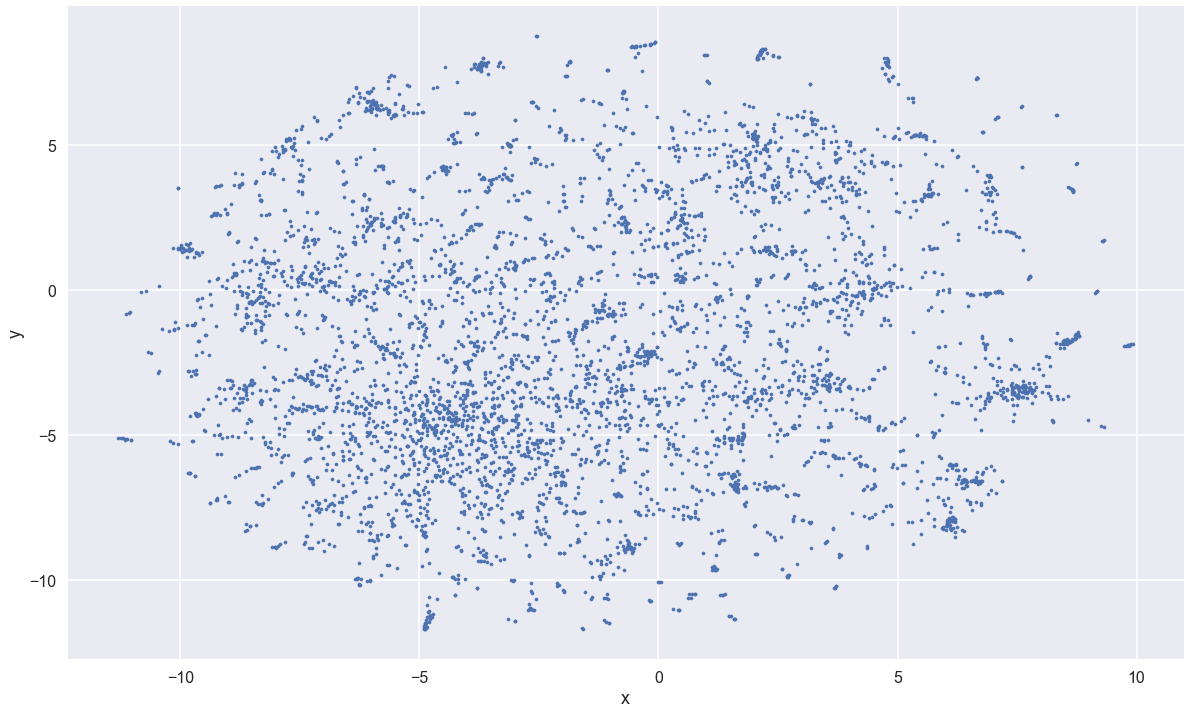

In [190]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [191]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

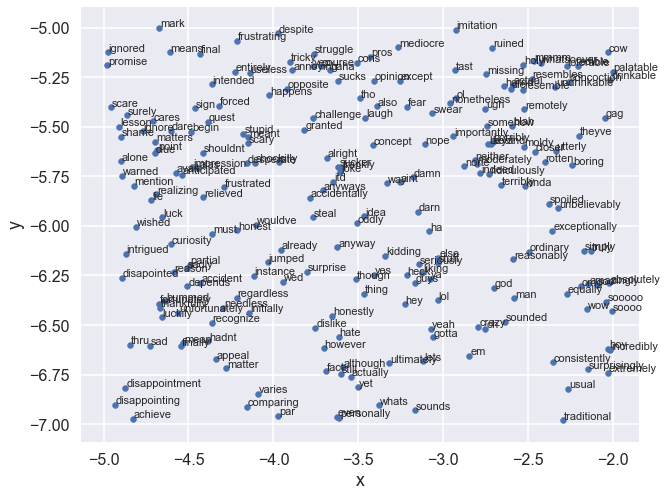

In [194]:
plot_region(x_bounds=(-5, -2), y_bounds=(-7, -5))

In [199]:
model.most_similar("disappointing")

[('disappointed', 0.7646054029464722),
 ('lacking', 0.6414973735809326),
 ('dissapointed', 0.6303361058235168),
 ('dissatisfied', 0.6162875294685364),
 ('inedible', 0.6154637336730957),
 ('disapointed', 0.6063592433929443),
 ('inferior', 0.5999597907066345),
 ('unpalatable', 0.5901276469230652),
 ('unappealing', 0.5878291726112366),
 ('tasteless', 0.5872617959976196)]

In [20]:
final=final[final.Text!='&#1056;&#1077;&#1096;&#1080;&#1083;&#1072; &#1079;&#1072;&#1082;&#1072;&#1079;&#1072;&#1090;&#1100; &#1101;&#1090;&#1080; &#1078;&#1077;&#1083;&#1072;&#1090;&#1080;&#1085;&#1082;&#1080;, &#1090;.&#1082;. &#1076;&#1086;&#1095;&#1082;&#1072; &#1087;&#1086;&#1096;&#1083;&#1072; &#1074; &#1096;&#1082;&#1086;&#1083;&#1091; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090; &#1089;&#1083;&#1072;&#1076;&#1086;&#1089;&#1090;&#1080;. &#1054;&#1095;&#1077;&#1085;&#1100; &#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#1103; &#1091;&#1087;&#1072;&#1082;&#1086;&#1074;&#1082;&#1072;. &#1050;&#1072;&#1082; &#1088;&#1072;&#1079; &#1089;&#1090;&#1086;&#1083;&#1100;&#1082;&#1086; &#1082;&#1086;&#1085;&#1092;&#1077;&#1090;, &#1082;&#1072;&#1082; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090;&#1089;&#1103;, &#1095;&#1090;&#1086;&#1073;&#1099; &#1089;&#1100;&#1077;&#1089;&#1090;&#1100; &#1080;&#1093; &#1079;&#1072; &#1087;&#1077;&#1088;&#1077;&#1084;&#1077;&#1085;&#1091;.']
final.shape

(364170, 12)

In [56]:
i=0
list_of_sent=[]
sum=0
featuresets=[]
for sent in final['Text'].values:
    i=0
    sum=0
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                if(cleaned_words.lower() not in stop):
                    i+=1
                    try:
                        sum+=model[cleaned_words.lower().encode('utf8')]
                    except:
                        i-=1
                        pass
                else:
                    continue
            else:
                continue        
    featuresets.append(sum/i)

In [57]:
y_train=final['Score'].values
y_train=y_train[:255000]
X_train=featuresets[:255000]
X_test=featuresets[255000:]
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)
prediction['Logistic-W2V'] = logreg.predict(X_test)

In [58]:
logreg.predict_proba(X_test)

array([[  9.82968127e-01,   1.70318732e-02],
       [  4.46030996e-01,   5.53969004e-01],
       [  9.40466267e-01,   5.95337326e-02],
       ..., 
       [  4.00081035e-02,   9.59991896e-01],
       [  3.49659075e-04,   9.99650341e-01],
       [  1.17966633e-02,   9.88203337e-01]])

In [59]:
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
print(metrics.classification_report(test_corpus, prediction['Logistic-W2V'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.80      0.59      0.68     18347
   negative       0.92      0.97      0.95     90823

avg / total       0.90      0.91      0.90    109170



In [60]:
from sklearn.metrics import accuracy_score
accuracy_score(test_corpus, prediction['Logistic-W2V'])

0.90623797746633694

In [61]:
clf = linear_model.SGDClassifier(l1_ratio=0)
clf.fit(X_train, y_train)
prediction['SVM-W2V'] = clf.predict(X_test)

In [62]:
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
print(metrics.classification_report(test_corpus, prediction['SVM-W2V'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.76      0.63      0.69     18347
   negative       0.93      0.96      0.94     90823

avg / total       0.90      0.90      0.90    109170



In [63]:
rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X_train)
clf = SGDClassifier()   
clf.fit(X_features,y_train)
test_features = rbf_feature.fit_transform(X_test)
prediction['RBF-SVM-W2V'] = clf.predict(test_features)

In [64]:
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
print(metrics.classification_report(test_corpus, prediction['RBF-SVM-W2V'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.00      0.00      0.00     18347
   negative       0.83      1.00      0.91     90823

avg / total       0.69      0.83      0.76    109170



## 3.7 Tf-Idf Word2Vec Featurization

In [224]:
i=0
str1=' '
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    filtered_sentence.append(cleaned_words.lower().encode('utf8'))
                else:
                    continue
            else:
                continue 
    str1 = ' '.join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)
    i+=1

In [225]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus=final_string
tfidf_vect = TfidfVectorizer()
X=tfidf_vect.fit_transform(corpus)

In [228]:
tfidf_vect.vocabulary_['good']

38357

In [21]:
final=final[final.Text!='T H I S  C H O C O L A T E  I S  A D D I C T I O N  I  C A N \'T  S T O P  E A T I N G  I T T T T T']
final=final[final.Text!='v e r y g o o d v e r y g o o d v e r y g o o d v e r y g o o d']
final=final[final.Text!='r8gtq9hrtp  d s h jnrgisdxc f j h xd d jn sd j g z  f j hg  xzz d d fg f g g h jk l l  iyt r wq s gv  hjk j g 9hpt fg g']
final.shape

(364167, 12)

In [265]:
i=0
list_of_sent=[]
sum=0
featuresets=[]
for sent in final['Text'].values:
    i=0
    sum=0
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha() & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    try:
                        i+=tfidf_vect.vocabulary_[cleaned_words.lower().encode('utf8')]
                        sum+=(model[cleaned_words.lower().encode('utf8')]*tfidf_vect.vocabulary_[cleaned_words.lower().encode('utf8')])
                    except:
                        try:
                            i-=tfidf_vect.vocabulary_[cleaned_words.lower().encode('utf8')]
                        except:
                            pass
                        pass
                else:
                    continue
            else:
                continue 
    featuresets.append(sum/i)

In [266]:
y_train=final['Score'].values
y_train=y_train[:255000]
X_train=featuresets[:255000]
X_test=featuresets[255000:]
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)
prediction['Logistic-TI-W2V'] = logreg.predict(X_test)

In [274]:
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
print(metrics.classification_report(test_corpus, prediction['Logistic-TI-W2V'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.79      0.54      0.64     18344
   negative       0.91      0.97      0.94     90823

avg / total       0.89      0.90      0.89    109167



In [268]:
clf = linear_model.SGDClassifier(l1_ratio=0)
clf.fit(X_train, y_train)
prediction['SVM-TI-W2V'] = clf.predict(X_test)

In [269]:
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
print(metrics.classification_report(test_corpus, prediction['SVM-TI-W2V'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.78      0.53      0.63     18344
   negative       0.91      0.97      0.94     90823

avg / total       0.89      0.90      0.89    109167



In [270]:
rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X_train)
clf = SGDClassifier()   
clf.fit(X_features,y_train)
test_features = rbf_feature.fit_transform(X_test)
prediction['RBF-SVM-TI-W2V'] = clf.predict(test_features)

In [271]:
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
print(metrics.classification_report(test_corpus, prediction['RBF-SVM-TI-W2V'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.00      0.00      0.00     18344
   negative       0.83      1.00      0.91     90823

avg / total       0.69      0.83      0.76    109167



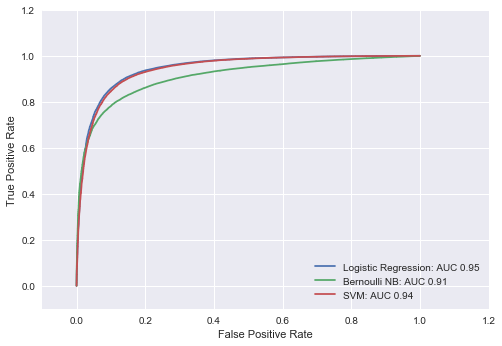

In [126]:
fpr, tpr, thresholds = metrics.roc_curve(test_corpus,[j for i,j in logreg.predict_proba(X_new_counts)],pos_label='positive')
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s: AUC %0.2f'% ('Logistic Regression',roc_auc))
fpr, tpr, thresholds = metrics.roc_curve(test_corpus,[j for i,j in model.predict_proba(X_new_counts)],pos_label='positive')
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s: AUC %0.2f'% ('Bernoulli NB',roc_auc))
fpr, tpr, thresholds = metrics.roc_curve(test_corpus,clf.decision_function(X_new_counts),pos_label='positive')
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s: AUC %0.2f'% ('SVM',roc_auc))
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

In [338]:
import gensim
cleaned=[i.split() for i in final['CleanedText'].values]
clean_model=gensim.models.Word2Vec(cleaned,min_count=5,size=200, workers=4)

In [365]:
(final['CleanedText'].values)[255000]

'bought product help allerg yorkshir terrier would vomit diarrhea frequent mani name brand holist qualiti brand found market switch brand usual sick switch immedi love lack willing eat brand instig switch would tri wait vomit wasnt bad know switch allergi anyway appitit brand strong vomit almost complet gone outsid run much asthma attack puke one thing must add dri veget product best serv follow day mix ad meat prepar enough food day follow day veget soft enough dog easili eat take much longer minut websit advertis complaint upfront food qualiti control dog eat recommend'

In [368]:
print X_train_tfidf[255000-1, tf_idf_vect.vocabulary_['rememb']]

0.0


In [369]:
i=0
list_of_sent=[]
sum=0
ind=0
featuresets=[]
for sent in (final['CleanedText'].values)[:255000]:
    i=0
    sum=0
    for w in sent.split():
        try:
            i+=X_train_tfidf[ind, tf_idf_vect.vocabulary_[w]]
            sum+=(clean_model[w]*X_train_tfidf[ind, tf_idf_vect.vocabulary_[w]])
        except:
            try:
                i-=X_train_tfidf[ind, tf_idf_vect.vocabulary_[w]]
            except:
                pass
        pass
    ind+=1
    if i>0:
        featuresets.append(sum/i)
    else:
        print ind

In [370]:
i=0
list_of_sent=[]
sum=0
ind=0
for sent in (final['CleanedText'].values)[255000:]:
    i=0
    sum=0
    for w in sent.split():
        try:
            i+=X_test_tfidf[ind, tf_idf_vect.vocabulary_[w]]
            sum+=(clean_model[w]*X_test_tfidf[ind, tf_idf_vect.vocabulary_[w]])
        except:
            try:
                i-=X_test_tfidf[ind, tf_idf_vect.vocabulary_[w]]
            except:
                pass
        pass
    ind+=1
    if i>0:
        featuresets.append(sum/i)
    else:
        print ind

In [371]:
len(featuresets)

364167

In [390]:
y_train=final['Score'].values
y_train=y_train[:255000]
X_train=featuresets[:255000]
X_test=featuresets[255000:]
logreg = linear_model.LogisticRegression(C=1,class_weight={'positive':1,'negative':3})
logreg.fit(X_train, y_train)
prediction['Logistic-W2V'] = logreg.predict(X_test)

In [391]:
test_corpus=final['Score'].values
test_corpus=test_corpus[255000:]
print(metrics.classification_report(test_corpus, prediction['Logistic-W2V']))

             precision    recall  f1-score   support

   negative       0.62      0.75      0.68     19067
   positive       0.94      0.90      0.92     90100

avg / total       0.89      0.88      0.88    109167



In [392]:
prediction['Logistic-W2V'] = logreg.predict(X_train)
print(metrics.classification_report(y_train, prediction['Logistic-W2V']))

             precision    recall  f1-score   support

   negative       0.59      0.74      0.66     38043
   positive       0.95      0.91      0.93    216957

avg / total       0.90      0.89      0.89    255000



1. Anderson-Darling Test 
2. If we were to add summary? 
